In [ ]:
import sys
!{sys.executable} -m pip install wrds

     |████████████████████████████████| 3.0MB 4.3MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Connecting to WRDS SQL engine

In [ ]:
import wrds
import pandas as pd
import numpy as np

db = wrds.Connection(wrds_username='jessicawijaya')


Enter your WRDS username [root]:jessicawijaya
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


## Download sp500 Index Membership (since 2000)

Instructions from 
https://wrds-www.wharton.upenn.edu/pages/support/applications/python-replications/historical-sp-500-index-constituents/


In [ ]:
### Step 2: Get SP500 Index Membership from CRSP
### I opt for the monthly frequency of the data, 
### but one can choose to work with crsp.dsp500list 
### if more precise date range is needed.

sp500 = db.raw_sql("""
                    select a.*, b.date, b.ret
                    from crsp.msp500list as a,
                    crsp.msf as b
                    where a.permno=b.permno
                    and b.date >= a.start and b.date<= a.ending
                    and b.date>='01/01/2000'
                    order by date;
                    """, date_cols=['start', 'ending', 'date'])

In [ ]:
### Step 3: Add Other Company Identifiers from CRSP.MSENAMES
### - You don't need this step if only PERMNO is required
### - This step aims to add TICKER, SHRCD, EXCHCD and etc. 

mse =db.raw_sql("""
                select comnam, ncusip, namedt, nameendt, 
                permno, shrcd, exchcd, hsiccd, ticker
                from crsp.msenames
                """, date_cols=['namedt', 'nameendt'])

# if nameendt is missing then set to today date
mse['nameendt']=mse['nameendt'].fillna(pd.to_datetime('today'))

# Merge with SP500 data
sp500_full = pd.merge(sp500, mse, how = 'left', on = 'permno')

# Impose the date range restrictions
sp500_full = sp500_full.loc[(sp500_full.date>=sp500_full.namedt) & (sp500_full.date<=sp500_full.nameendt)]


In [ ]:
### Step 4: Add Compustat Identifiers
### - Link with Compustat's GVKEY and IID if need to work with fundamental data
### - Linkage is done through crsp.ccmxpf_linktable

ccm = db.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno,
                  linktype, linkprim, linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

# Merge the CCM data with S&P500 data
# First just link by matching PERMNO
sp500ccm = pd.merge(sp500_full, ccm, how='left', on=['permno'])

# Then set link date bounds
sp500ccm = sp500ccm.loc[(sp500ccm['date']>=sp500ccm['linkdt'])\
                        &(sp500ccm['date']<=sp500ccm['linkenddt'])]

# Rearrange columns for final output

sp500ccm = sp500ccm.drop(columns=['namedt', 'nameendt', 'linktype', \
                                  'linkprim', 'linkdt', 'linkenddt'])
sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip',\
                     'shrcd', 'exchcd', 'hsiccd', 'ticker', \
                     'gvkey', 'iid', 'start', 'ending', 'ret']]

In [ ]:
# saving list of companies to txt file -> fed to compustat page for web query
np.savetxt('/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/sp500gvkey.txt', sp500ccm['gvkey'].unique(), fmt="%s",delimiter=' ')
sp500ccm.to_csv("/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/sp500ccm.csv")

## Preprocess Key Dev data

- Read output from Compustat Web Query
- clean data (drop rows with null headlines/key dev articles)
- process the dates
- merge with sp500 data above to get the company ticker

In [ ]:
import pandas as pd
import numpy as np

sp500ccm = pd.read_csv("/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/sp500ccm.csv")
gvkey_ticker_mapping = sp500ccm[['gvkey','ticker']].drop_duplicates('gvkey', keep='last')

df_keydev = pd.read_csv("/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/raw_keydev_data.csv")

In [ ]:
print(df_keydev.shape)
df_keydev.head()

(1070993, 13)


,keydevid,companyid,companyname,keydeveventtypeid,keydevstatusid,keydevtoobjectroletypeid,announcedate,announcetime,enterdate,entertime,gvkey,headline,situation
0,2,18671,Albemarle Corporation,3.0,1.0,1.0,20030423.0,12:00:00 AM,20010101.0,12:00:00 AM,29751.0,Albemarle Corporation is considering acquisitions.,Albemarle Corporation announced that it is interested in making acquisitions in the fine chemica...
1,4,18921,AT&T Corp.,3.0,1.0,1.0,20030131.0,12:00:00 AM,20010101.0,12:00:00 AM,1581.0,AT&T Corp. is considering acquisitions.,"AT&T Corp. announced that it could use up to $5 billion to acquire assets, both domestically and..."
2,6,19007,"Baker Hughes, a GE company, LLC",3.0,1.0,1.0,20030213.0,12:00:00 AM,20010101.0,12:00:00 AM,1976.0,Baker Hughes Incorporated is considering acquisitions.,Baker Hughes Inc. is evaluating various strategic options including external investment opportun...
3,9,19049,Bank of America Corporation,3.0,1.0,1.0,20030518.0,12:00:00 AM,20010101.0,12:00:00 AM,7647.0,Bank of America Corporation is considering acquisitions.,Bank of America is looking for acquisitions in the UK and has held exploratory talks with severa...
4,13,19109,Truist Financial Corporation,3.0,1.0,1.0,20030424.0,12:00:00 AM,20010101.0,12:00:00 AM,11856.0,BB&T Corporation is considering acquisitions.,BB&T Corp. is looking for possible acquisitions in Ohio and neighboring states.


In [ ]:
df_keydev_cleaned = df_keydev.dropna()
df_keydev_cleaned.shape

(989538, 13)

In [ ]:
df_keydev_cleaned.loc[:,'announcedate'] = pd.to_datetime(df_keydev_cleaned['announcedate'].astype(int).astype(str), format='%Y%m%d')
df_keydev_cleaned.loc[:,'enterdate'] = pd.to_datetime(df_keydev_cleaned['enterdate'].astype(int).astype(str), format='%Y%m%d')
print(df_keydev_cleaned.shape)
df_keydev_cleaned.head()


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


(989538, 13)


,keydevid,companyid,companyname,keydeveventtypeid,keydevstatusid,keydevtoobjectroletypeid,announcedate,announcetime,enterdate,entertime,gvkey,headline,situation
0,2,18671,Albemarle Corporation,3.0,1.0,1.0,2003-04-23,12:00:00 AM,2001-01-01,12:00:00 AM,29751.0,Albemarle Corporation is considering acquisitions.,Albemarle Corporation announced that it is interested in making acquisitions in the fine chemica...
1,4,18921,AT&T Corp.,3.0,1.0,1.0,2003-01-31,12:00:00 AM,2001-01-01,12:00:00 AM,1581.0,AT&T Corp. is considering acquisitions.,"AT&T Corp. announced that it could use up to $5 billion to acquire assets, both domestically and..."
2,6,19007,"Baker Hughes, a GE company, LLC",3.0,1.0,1.0,2003-02-13,12:00:00 AM,2001-01-01,12:00:00 AM,1976.0,Baker Hughes Incorporated is considering acquisitions.,Baker Hughes Inc. is evaluating various strategic options including external investment opportun...
3,9,19049,Bank of America Corporation,3.0,1.0,1.0,2003-05-18,12:00:00 AM,2001-01-01,12:00:00 AM,7647.0,Bank of America Corporation is considering acquisitions.,Bank of America is looking for acquisitions in the UK and has held exploratory talks with severa...
4,13,19109,Truist Financial Corporation,3.0,1.0,1.0,2003-04-24,12:00:00 AM,2001-01-01,12:00:00 AM,11856.0,BB&T Corporation is considering acquisitions.,BB&T Corp. is looking for possible acquisitions in Ohio and neighboring states.


In [ ]:
df_keydev_cleaned = pd.merge(df_keydev_cleaned, gvkey_ticker_mapping, how='left', left_on="gvkey", right_on="gvkey")
print(df_keydev_cleaned.shape)
df_keydev_cleaned.head()

(989538, 14)


,keydevid,companyid,companyname,keydeveventtypeid,keydevstatusid,keydevtoobjectroletypeid,announcedate,announcetime,enterdate,entertime,gvkey,headline,situation,ticker
0,2,18671,Albemarle Corporation,3.0,1.0,1.0,2003-04-23,12:00:00 AM,2001-01-01,12:00:00 AM,29751.0,Albemarle Corporation is considering acquisitions.,Albemarle Corporation announced that it is interested in making acquisitions in the fine chemica...,ALB
1,4,18921,AT&T Corp.,3.0,1.0,1.0,2003-01-31,12:00:00 AM,2001-01-01,12:00:00 AM,1581.0,AT&T Corp. is considering acquisitions.,"AT&T Corp. announced that it could use up to $5 billion to acquire assets, both domestically and...",T
2,6,19007,"Baker Hughes, a GE company, LLC",3.0,1.0,1.0,2003-02-13,12:00:00 AM,2001-01-01,12:00:00 AM,1976.0,Baker Hughes Incorporated is considering acquisitions.,Baker Hughes Inc. is evaluating various strategic options including external investment opportun...,BHI
3,9,19049,Bank of America Corporation,3.0,1.0,1.0,2003-05-18,12:00:00 AM,2001-01-01,12:00:00 AM,7647.0,Bank of America Corporation is considering acquisitions.,Bank of America is looking for acquisitions in the UK and has held exploratory talks with severa...,BAC
4,13,19109,Truist Financial Corporation,3.0,1.0,1.0,2003-04-24,12:00:00 AM,2001-01-01,12:00:00 AM,11856.0,BB&T Corporation is considering acquisitions.,BB&T Corp. is looking for possible acquisitions in Ohio and neighboring states.,TFC


In [ ]:
df_keydev_cleaned[df_keydev_cleaned['ticker'].isna()][['gvkey','companyname']].drop_duplicates()

,gvkey,companyname
2029,111970.0,"Nielsen Media Research, Inc."
762503,163500.0,Paragon Offshore Drilling LLC


In [ ]:
# manual input for these 2 companies:

# Nielsen Media Research, Inc.
df_keydev_cleaned.loc[df_keydev_cleaned['gvkey']==111970, 'ticker'] = 'NLSN'

# Paragon Offshore Drilling LLC
df_keydev_cleaned.loc[df_keydev_cleaned['gvkey']==163500, 'ticker'] = 'PGNPQ'

df_keydev_cleaned[df_keydev_cleaned['ticker'].isna()]

,keydevid,companyid,companyname,keydeveventtypeid,keydevstatusid,keydevtoobjectroletypeid,announcedate,announcetime,enterdate,entertime,gvkey,headline,situation,ticker


In [ ]:
df_keydev_cleaned['companyname'].value_counts(ascending=False).head(20)

JPMorgan Chase & Co.                           17407
The Goldman Sachs Group, Inc.                  14159
Citigroup Inc.                                 11503
International Business Machines Corporation    11188
Microsoft Corporation                          10320
Bank of America Corporation                     8586
AT&T Inc.                                       7548
The Boeing Company                              6487
Cisco Systems, Inc.                             6171
HP Inc.                                         5895
Wells Fargo & Company                           5832
Oracle Corporation                              5623
Lockheed Martin Corporation                     5595
General Electric Company                        5116
Pfizer Inc.                                     4829
Ford Motor Company                              4707
Alphabet Inc.                                   4572
Intel Corporation                               4572
Motorola Solutions, Inc.                      

In [ ]:
df_keydev_cleaned['WC_headline'] = df_keydev_cleaned['headline'].str.split().str.len()
df_keydev_cleaned['WC_situation'] = df_keydev_cleaned['situation'].str.split().str.len()

In [ ]:
df_keydev_cleaned.to_csv("/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/preprocessed_keydev_data.csv", index=False)

### Exploring the key dev for qualcomm longest texts

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# df_keydev_cleaned = pd.read_csv("/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/preprocessed_keydev_data.csv")
# df_keydev_cleaned.head()

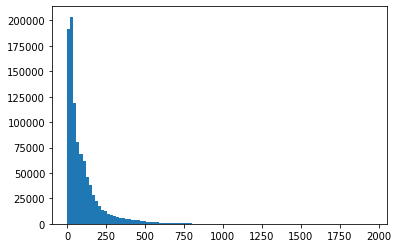

In [ ]:
plt.hist(df_keydev_cleaned['WC_situation'], bins=100)
plt.show()

In [ ]:
pd.set_option('display.max_colwidth', 100)

QCOM_data = df_keydev_cleaned[df_keydev_cleaned['ticker']=='QCOM']
QCOM_data.head()

,keydevid,companyid,companyname,keydeveventtypeid,keydevstatusid,keydevtoobjectroletypeid,announcedate,announcetime,enterdate,entertime,gvkey,headline,situation,ticker,WC_headline,WC_situation
379,45874,33493,QUALCOMM Incorporated,41.0,1.0,1.0,2003-10-27,12:00:00 AM,2003-10-30,11:52:00 AM,24800.0,QUALCOMM Announces Enhanced FleetAdvisor Solution With Hours of Service,"QUALCOMM Inc. announced the latest version of the FleetAdvisor(R) system, which includes support...",QCOM,9,79
381,45878,33493,QUALCOMM Incorporated,23.0,1.0,1.0,2003-10-27,12:00:00 AM,2003-10-30,11:54:00 AM,24800.0,QUALCOMM Selected by The H.T. Hackney Company for Fleet Management Solution to Manage Hours of S...,"QUALCOMM Inc. announced that The H.T. Hackney Company, one of the largest wholesale distributors...",QCOM,17,80
1121,61143,33493,QUALCOMM Incorporated,41.0,1.0,1.0,2003-09-29,12:00:00 AM,2003-09-30,9:38:00 PM,24800.0,QUALCOMM Announces CSM6800 and MSM6800 End-to-End Solution For CDMA2000 1xEV-DO Revision A,"QUALCOMM Incorporated, pioneer and world leader of Code Division Multiple Access (CDMA) digital ...",QCOM,12,72
1788,75616,33493,QUALCOMM Incorporated,23.0,1.0,1.0,2003-04-15,12:00:00 AM,2003-09-05,6:35:00 PM,24800.0,Qualcomm Telular enter unit license agreement,Qualcomm Incorporated announced a multi-million dollar CDMA unit license agreement with Telular ...,QCOM,6,50
1859,76179,33493,QUALCOMM Incorporated,41.0,1.0,1.0,2003-08-06,12:00:00 AM,2003-09-04,7:09:00 PM,24800.0,"QUALCOMM Announces Sampling of the MSM6250 Solution for WCDMA (UMTS), GSM and GPRS",QUALCOMM Incorporated announced sampling to customers of the MSM6250(TM) chipset and system soft...,QCOM,13,110


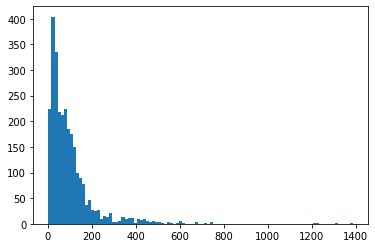

In [ ]:
plt.hist(QCOM_data['WC_situation'], bins=100)
plt.show()

In [ ]:
QCOM_data[QCOM_data['WC_situation']<5].sort_values('WC_situation').head(10)

,keydevid,companyid,companyname,keydeveventtypeid,keydevstatusid,keydevtoobjectroletypeid,announcedate,announcetime,enterdate,entertime,gvkey,headline,situation,ticker,WC_headline,WC_situation
283647,6272307,33493,QUALCOMM Incorporated,50.0,1.0,1.0,2009-03-03,2:01:00 PM,2009-03-03,5:11:00 PM,24800.0,QUALCOMM Inc. - Shareholder/Analyst Call,Annual stockholders' meeting,QCOM,5,3
539093,214293217,33493,QUALCOMM Incorporated,50.0,1.0,1.0,2012-03-06,12:00:00 AM,2012-07-17,5:02:00 AM,24800.0,QUALCOMM Incorporated - Shareholder/Analyst Call,Annual meeting of stockholders,QCOM,5,4
641608,257552054,33493,QUALCOMM Incorporated,50.0,1.0,1.0,2014-02-27,7:39:00 AM,2014-02-27,2:48:00 AM,24800.0,QUALCOMM Incorporated - Shareholder/Analyst Call,Annual Meeting of Stockholders,QCOM,5,4
766320,327563465,33493,QUALCOMM Incorporated,50.0,1.0,1.0,2016-03-07,7:24:00 PM,2016-03-07,2:50:00 PM,24800.0,QUALCOMM Incorporated - Shareholder/Analyst Call,Annual Meeting of Stockholders,QCOM,5,4
819891,421903801,33493,QUALCOMM Incorporated,50.0,1.0,1.0,2017-03-01,12:03:00 AM,2017-02-28,2:34:00 PM,24800.0,QUALCOMM Incorporated - Shareholder/Analyst Call,Annual meeting of stockholders,QCOM,5,4


In [ ]:
for i in [100, 500, 1000, 1500, 2000]:
  print(QCOM_data['situation'].iloc[i])

QUALCOMM Inc. announced that its MSM6200(TM) WCDMA (UMTS) chipset solution has been tested against and was successfully validated by all 13 worldwide WCDMA (UMTS) infrastructure vendors. UALCOMM's chipset solution is the first to achieve voice, circuit and packet data interoperability with all WCDMA (UMTS) infrastructure vendors, enabling a wide range of handset manufacturers to offer wireless devices that will seamlessly operate on any WCDMA network in the world. QUALCOMM's field-tested solutions ensure reduced time-to-market for manufacturers, while providing wireless operators with reliable products to effectively support their consumer and enterprise service offerings.
QUALCOMM Inc. announced a $200,000 partnership with the University of São Paulo's Polytechnic School. This is part of the company's global strategy of investing in education initiatives and support to technological knowledge. Qualcomm's initial investment will be allocated to the sponsorship of doctorate scholarships

### Filtering news

In [ ]:
# check if we should drop rows that contain less than 10 words for column "situation"
# most probably we will not have any meaningful info for these short texts
display(df_keydev_cleaned[df_keydev_cleaned['WC_situation']<=8].sort_values('WC_situation').tail(10))

,keydevid,companyid,companyname,keydeveventtypeid,keydevstatusid,keydevtoobjectroletypeid,announcedate,announcetime,enterdate,entertime,gvkey,headline,situation,ticker,WC_headline,WC_situation
705420,288132655,311679,Valero Energy Corporation,87.0,1.0,1.0,2015-03-10,12:00:00 AM,2015-03-11,3:20:00 AM,15247.0,Valero Energy Corporation has announced a Fixed-Income Offering.,Valero Energy Corporation has announced a Fixed-Income Offering.,VLO,8,8
705421,288132656,311679,Valero Energy Corporation,87.0,1.0,1.0,2015-03-10,12:00:00 AM,2015-03-11,3:20:00 AM,15247.0,Valero Energy Corporation has announced a Fixed-Income Offering.,Valero Energy Corporation has announced a Fixed-Income Offering.,VLO,8,8
420073,115794865,286163,"The Manitowoc Company, Inc.",93.0,1.0,1.0,2010-11-11,12:00:00 AM,2010-11-15,8:01:00 AM,6994.0,Manitowoc Co. Inc. has filed a Shelf Registration.,Manitowoc Co. Inc. has filed a Shelf Registration.,MTW,8,8
705423,288141198,314842,Marathon Oil Corporation,87.0,1.0,1.0,2009-02-11,12:00:00 AM,2015-03-11,3:45:00 AM,7017.0,Marathon Oil Corporation has announced a Fixed-Income Offering.,Marathon Oil Corporation has announced a Fixed-Income Offering.,MRO,8,8
705424,288142279,314842,Marathon Oil Corporation,87.0,1.0,1.0,2007-07-26,12:00:00 AM,2015-03-11,3:48:00 AM,7017.0,Marathon Oil Corporation has announced a Fixed-Income Offering.,Marathon Oil Corporation has announced a Fixed-Income Offering.,MRO,8,8
705425,288143753,314842,Marathon Oil Corporation,87.0,1.0,1.0,2009-02-11,12:00:00 AM,2015-03-11,3:58:00 AM,7017.0,Marathon Oil Corporation has announced a Fixed-Income Offering.,Marathon Oil Corporation has announced a Fixed-Income Offering.,MRO,8,8
705426,288145280,93030,Range Resources Corporation,87.0,1.0,1.0,2009-05-11,12:00:00 AM,2015-03-11,4:04:00 AM,6788.0,Range Resources Corporation has announced a Fixed-Income Offering.,Range Resources Corporation has announced a Fixed-Income Offering.,RRC,8,8
189262,4552923,179862,"Kinder Morgan Kansas, Inc.",95.0,1.0,1.0,2005-01-29,12:00:00 AM,2007-06-28,6:07:00 AM,6310.0,Kinder Morgan Inc. added to Russell 3000 Index,Kinder Morgan Inc. added to Russell 3000 Index,KMI,8,8
705417,288126489,93030,Range Resources Corporation,87.0,1.0,1.0,2008-04-28,12:00:00 AM,2015-03-11,2:55:00 AM,6788.0,Range Resources Corporation has announced a Fixed-Income Offering.,Range Resources Corporation has announced a Fixed-Income Offering.,RRC,8,8
767642,328335121,291703,Newell Brands Inc.,87.0,1.0,1.0,2016-03-15,12:00:00 AM,2016-03-15,7:35:00 PM,7875.0,Newell Rubbermaid Inc. has announced a Fixed-Income Offering.,Newell Rubbermaid Inc. has announced a Fixed-Income Offering.,NWL,8,8


In [16]:
# select only relevant columns
df_keydev_cleaned['datetime'] = df_keydev_cleaned['announcedate'].apply(str) + ' ' + df_keydev_cleaned['announcetime']

df_final = df_keydev_cleaned[df_keydev_cleaned['WC_situation']>8] #drop rows that has less than 8 word counts
df_final = df_final[['companyname', 'ticker', 'datetime', 'situation']] #extract the useful columns only
df_final.head()

,companyname,ticker,datetime,situation
0,Albemarle Corporation,ALB,2003-04-23 12:00:00 AM,Albemarle Corporation announced that it is interested in making acquisitions in the fine chemica...
1,AT&T Corp.,T,2003-01-31 12:00:00 AM,"AT&T Corp. announced that it could use up to $5 billion to acquire assets, both domestically and..."
2,"Baker Hughes, a GE company, LLC",BHI,2003-02-13 12:00:00 AM,Baker Hughes Inc. is evaluating various strategic options including external investment opportun...
3,Bank of America Corporation,BAC,2003-05-18 12:00:00 AM,Bank of America is looking for acquisitions in the UK and has held exploratory talks with severa...
4,Truist Financial Corporation,TFC,2003-04-24 12:00:00 AM,BB&T Corp. is looking for possible acquisitions in Ohio and neighboring states.


In [17]:
# drop duplicated news
df_final.drop_duplicates().shape

(889689, 4)

In [18]:
# df_final.to_csv("/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/final_keydev_data.csv", index=False)

## Write to TFRecords 

In [4]:
!pip3 install transformers

     |████████████████████████████████| 1.3MB 4.1MB/s 
     |████████████████████████████████| 2.9MB 21.7MB/s 
     |████████████████████████████████| 1.1MB 53.3MB/s 
     |████████████████████████████████| 890kB 43.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=65ddb17cef1f579bb9078bea5c0b372fe91e527177587b455aec81bb049ae52c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [24]:
import pandas as pd
from tqdm import tqdm

from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# df_final = pd.read_csv("/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/final_keydev_data.csv")

In [19]:
df_final.tail()

,companyname,ticker,datetime,situation
989532,Bristol-Myers Squibb Company,BMY,2020-02-14 11:30:00 AM,Bristol-Myers Squibb Company announced the results of a robust multinational inflammatory bowel ...
989533,Teleflex Incorporated,TFX,2020-02-14 10:00:00 PM,Teleflex Incorporated has announced a worldwide voluntary recall of the COMFORT FLO Humidificati...
989534,McAfee LLC,MFE,2020-02-13 5:02:00 AM,McAfee announced its extension of the long-standing partnership with Samsung to protect consumer...
989535,"Amazon.com, Inc.",AMZN,2020-02-12 2:00:00 PM,"Franchise Holdings International Inc. ('Company') Worksport Ltd.’s parent company, expects to so..."
989537,Equifax Inc.,EFX,2020-02-14 12:48:00 PM,Equifax Inc. and Inventory Command Center LLC (ICC) announced a new partnership to help automoti...


In [6]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.
# Credit: https://www.tensorflow.org/tutorials/load_data/tfrecord

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

tfrecords_filename = '/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/keydev.tfrecords'
writer = tf.io.TFRecordWriter(tfrecords_filename)

for idx in tqdm(range(len(df_final))):
  keydev_token = tokenizer.encode_plus(df_final.iloc[idx]['situation'],
                                       add_special_tokens = True, # add [CLS], [SEP]
                                       max_length = 512, 
                                       padding='max_length',
                                       return_attention_mask = True, # add attention mask to not focus on pad tokens
                                       truncation='longest_first',
                                       return_tensors="tf")
  
  keydev_input = keydev_token['input_ids'].numpy().tostring()
  keydev_token_type = keydev_token['token_type_ids'].numpy().tostring()
  keydev_attention = keydev_token['attention_mask'].numpy().tostring()

  ticker = df_final.iloc[idx]['ticker']
  datetime = df_final.iloc[idx]['datetime']

  # Create tf.train.Example
  feature={
      'ticker': _bytes_feature(ticker.encode('utf-8')), 
      'datetime' : _bytes_feature(datetime.encode('utf-8')),
      'keydev_input_ids': _bytes_feature(keydev_input),
      'keydev_token_type_ids': _bytes_feature(keydev_token_type),
      'keydev_attention_mask': _bytes_feature(keydev_attention)
  }

  features=tf.train.Features(feature=feature)
  example = tf.train.Example(features=features)

  # Wrtie the TFRecord
  writer.write(example.SerializeToString())

# Close the TFRecord file
writer.close()

100%|██████████| 954166/954166 [47:30<00:00, 334.77it/s]


## Build Pipeline

In [26]:
filenames = ['/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/keydev.tfrecords']
raw_dataset = tf.data.TFRecordDataset(filenames)

for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    # print(example)


def _parse_feature_function(example_proto):
  # Create a dictionary describing the features.
  raw_features={
      'ticker': tf.io.FixedLenFeature([], tf.string), 
      'datetime' : tf.io.FixedLenFeature([], tf.string),
      'keydev_input_ids': tf.io.FixedLenFeature([], tf.string),
      'keydev_token_type_ids': tf.io.FixedLenFeature([], tf.string),
      'keydev_attention_mask': tf.io.FixedLenFeature([], tf.string)
  }

  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, raw_features)

parsed_dataset = raw_dataset.map(_parse_feature_function)
parsed_dataset

<MapDataset shapes: {datetime: (), keydev_attention_mask: (), keydev_input_ids: (), keydev_token_type_ids: (), ticker: ()}, types: {datetime: tf.string, keydev_attention_mask: tf.string, keydev_input_ids: tf.string, keydev_token_type_ids: tf.string, ticker: tf.string}>

In [28]:
i = 0
for feature in parsed_dataset:
    i += 1
    print(feature['ticker'])
    print(feature['datetime'])
    if i > 10:
        break

tf.Tensor(b'ALB', shape=(), dtype=string)
tf.Tensor(b'2003-04-23 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'T', shape=(), dtype=string)
tf.Tensor(b'2003-01-31 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'BHI', shape=(), dtype=string)
tf.Tensor(b'2003-02-13 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'BAC', shape=(), dtype=string)
tf.Tensor(b'2003-05-18 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'TFC', shape=(), dtype=string)
tf.Tensor(b'2003-04-24 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'TGNA', shape=(), dtype=string)
tf.Tensor(b'2003-06-02 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'GDT', shape=(), dtype=string)
tf.Tensor(b'2003-05-05 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'INTU', shape=(), dtype=string)
tf.Tensor(b'2003-05-14 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'MSFT', shape=(), dtype=string)
tf.Tensor(b'2003-03-02 12:00:00 AM', shape=(), dtype=string)
tf.Tensor(b'ORCL', shape=(), dtype=string)
tf.Tensor(b'2003-08-07 12:00:

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size=64

# Structure the data for training
def structure_data(data):  

  # ticker = data['ticker'] 
  # dates = data['datetime'] 

  keydev_input = tf.io.decode_raw(data['keydev_input_ids'], tf.int32)
  keydev_token = tf.io.decode_raw(data['keydev_token_type_ids'], tf.int32)
  keydev_attention = tf.io.decode_raw(data['keydev_attention_mask'], tf.int32)

  return (keydev_input, keydev_token, keydev_attention)
  
  # target_return = ... #TODO
  # return ((keydev_input, keydev_token, keydev_attention), target_return )


tfrecords_pattern_path = '/content/drive/MyDrive/abnormal-distribution-project-data/compustat_keydev/keydev.tfrecords'
train_files = tf.io.matching_files(tfrecords_pattern_path)
train_files = tf.random.shuffle(train_files)
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)

train = train_dataset.interleave(tf.data.TFRecordDataset)
train = train.map(_parse_feature_function, num_parallel_calls=AUTOTUNE)
train = train.map(structure_data, num_parallel_calls=AUTOTUNE)
train = train.batch(batch_size)

In [30]:
sample_data = []
for data in train.take(1):
  sample_data.append(data)

sample_data[0]

(<tf.Tensor: shape=(64, 512), dtype=int32, numpy=
 array([[ 101, 2632, 4783, ...,    0,    0,    0],
        [ 101, 2012, 1004, ...,    0,    0,    0],
        [ 101, 6243, 8099, ...,    0,    0,    0],
        ...,
        [ 101, 1058, 2546, ...,    0,    0,    0],
        [ 101, 1058, 2546, ...,    0,    0,    0],
        [ 101, 4054, 3361, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(64, 512), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>)

In [31]:
bert = TFBertModel.from_pretrained('bert-base-uncased', return_dict=True)
bert.trainable = False

outputs = bert(sample_data[0][0], token_type_ids=sample_data[0][1], attention_mask=sample_data[0][2] )
outputs

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


TFBaseModelOutputWithPooling([('last_hidden_state',
                               <tf.Tensor: shape=(64, 512, 768), dtype=float32, numpy=
                               array([[[-6.50838196e-01, -4.02279258e-01, -2.66591251e-01, ...,
                                         1.17674023e-02,  3.53079796e-01,  1.42342851e-01],
                                       [ 6.67687505e-02, -8.47910583e-01,  6.81452900e-02, ...,
                                         5.35668731e-01,  9.05085325e-01,  6.01927161e-01],
                                       [-8.35709870e-01, -6.63076103e-01,  7.72161365e-01, ...,
                                        -9.60879326e-02,  5.11749685e-01,  3.83423686e-01],
                                       ...,
                                       [-6.01221502e-01, -6.55887723e-01, -2.47013122e-01, ...,
                                         4.90899622e-01,  3.91430378e-01, -6.15401328e-01],
                                       [-2.63597012e-01, -1.59181

In [33]:
outputs[0]

<tf.Tensor: shape=(64, 512, 768), dtype=float32, numpy=
array([[[-6.50838196e-01, -4.02279258e-01, -2.66591251e-01, ...,
          1.17674023e-02,  3.53079796e-01,  1.42342851e-01],
        [ 6.67687505e-02, -8.47910583e-01,  6.81452900e-02, ...,
          5.35668731e-01,  9.05085325e-01,  6.01927161e-01],
        [-8.35709870e-01, -6.63076103e-01,  7.72161365e-01, ...,
         -9.60879326e-02,  5.11749685e-01,  3.83423686e-01],
        ...,
        [-6.01221502e-01, -6.55887723e-01, -2.47013122e-01, ...,
          4.90899622e-01,  3.91430378e-01, -6.15401328e-01],
        [-2.63597012e-01, -1.59181669e-01, -9.04598832e-02, ...,
          6.00484610e-01,  3.07104409e-01, -4.10008788e-01],
        [-2.21569344e-01, -1.48135141e-01, -9.72424448e-02, ...,
          7.08984017e-01,  4.06267673e-01, -3.17769706e-01]],

       [[-4.40679193e-01, -4.38155234e-01, -1.17139101e-01, ...,
         -6.27985299e-02,  2.99411029e-01,  2.48281315e-01],
        [ 3.61321747e-01, -3.31670493e-02, -4.0

In [36]:
outputs[1]

<tf.Tensor: shape=(64, 768), dtype=float32, numpy=
array([[-0.87784773, -0.5359736 , -0.8674283 , ..., -0.5310161 ,
        -0.6120211 ,  0.5852444 ],
       [-0.8931057 , -0.47095042, -0.86573184, ..., -0.66519785,
        -0.6445427 ,  0.72697043],
       [-0.9273627 , -0.53929293, -0.9647456 , ..., -0.78622067,
        -0.64884853,  0.78406596],
       ...,
       [-0.8535607 , -0.47524878, -0.9195279 , ..., -0.48913783,
        -0.58292574,  0.72268   ],
       [-0.8509703 , -0.40516338, -0.8675324 , ..., -0.5447209 ,
        -0.5575396 ,  0.6730701 ],
       [-0.8289722 , -0.50163406, -0.94280034, ..., -0.6901381 ,
        -0.6156206 ,  0.62578666]], dtype=float32)>